# Gaussian Processes

* A Gaussian *Process* (GP) is a generalization of the Gaussian probability *distribution*
* GPs asign a *prior probability over functions*. The speciﬁcation of the prior is important, because it ﬁxes the properties of the functions considered for inference.
* The properties of a GP are induced by the **covariance function** of the process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import inv
from numpy.random import multivariate_normal, seed, randn, rand
from sklearn.preprocessing import PolynomialFeatures

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=3, suppress=True)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
nsteps = 100
x = np.linspace(-1, 1, nsteps)

> The problem of learning in Gaussian processes is exactly the problem of ﬁnding suitable properties for the covariance function.

## function-space view

**Definition**: A Gaussian process is a collection of random variables, any ﬁnite number of which have a joint Gaussian distribution.

A Gaussian process is completely speciﬁed by its mean function $m({\bf x})$ and covariance function $k({\bf x}, {\bf x}')$:

$$
\begin{align}
     m({\bf x}) &= \mathbb{E}[y({\bf x})]\\
    k({\bf x}, {\bf x}') &= \mathbb{E}\left[(y({\bf x}) - m({\bf x})) (y({\bf x}') - m({\bf x}'))^T\right]
\end{align}
$$

We write the Gaussian Process as

$$
    y({\bf x}) \sim \mathcal{GP}\big(m({\bf x}), k({\bf x}, {\bf x}')\big)
$$

## Explict definition of the kernel Matrix

If our prior function is determined by a linear model, i.e, $y({\bf x}) = {\bf w}^T\phi({\bf x})$. Specifying a prior distribution for the weights, induces a prior distribution over y.

Suppose, for example, that ${\bf w}\sim \mathcal{N}({\bf 0}, {\bf I})$. Then,

$$
\begin{align}
     m({\bf X}) &= \mathbb{E}[y({\bf X})] \\
                &= \mathbb{E}[\boldsymbol\Phi {\bf w}]\\
                &= \boldsymbol\Phi \mathbb{E}[{\bf w}]\\
                &= {\bf 0}\\
\end{align}
$$

Furthermore,
$$
\begin{align}
    k({\bf x}, {\bf x}') &= \mathbb{E}\left[(y({\bf X}) - m({\bf X}))^T (y({\bf X}') - m({\bf X}'))\right]\\
                         &= \mathbb{E}\left[(\boldsymbol\Phi {\bf w}) (\boldsymbol\Phi {\bf w})^T\right]\\
                         &= \mathbb{E}\left[\boldsymbol\Phi {\bf w}{\bf w}^T \boldsymbol\Phi^T\right]\\
                         &= \boldsymbol\Phi\mathbb{E}\left[{\bf w}{\bf w}^T\right]\boldsymbol\Phi^T\\
                         &= \boldsymbol\Phi{\bf I}\boldsymbol\Phi^T\\
\end{align}
$$


Hence, our prior function is

$$
    y({\bf x}) \sim \mathcal{GP}\big({\bf 0}, \boldsymbol\Phi\boldsymbol\Phi^T\big)
$$

<AxesSubplot:>

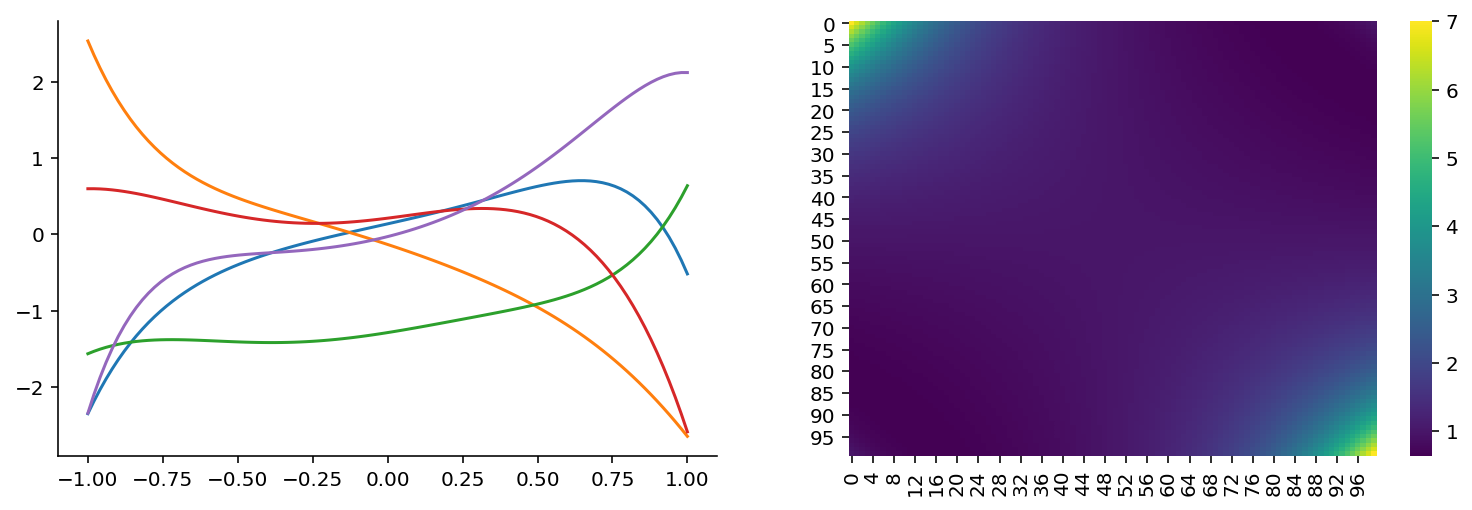

In [4]:
seed(314)
# mean function
E = np.zeros_like(x)
phi = PolynomialFeatures(degree=6).fit_transform(x[:, np.newaxis])
# covariance function 
Phi = phi @ phi.T

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(x, np.random.multivariate_normal(E, Phi, size=5).T)
sns.heatmap(Phi, cmap="viridis", ax=ax[1])

## Implicit definition of the kernel Matrix

> We can also deﬁne the kernel function directly, rather than indirectly through a choice of basis function 

### Gaussian Kernel Process

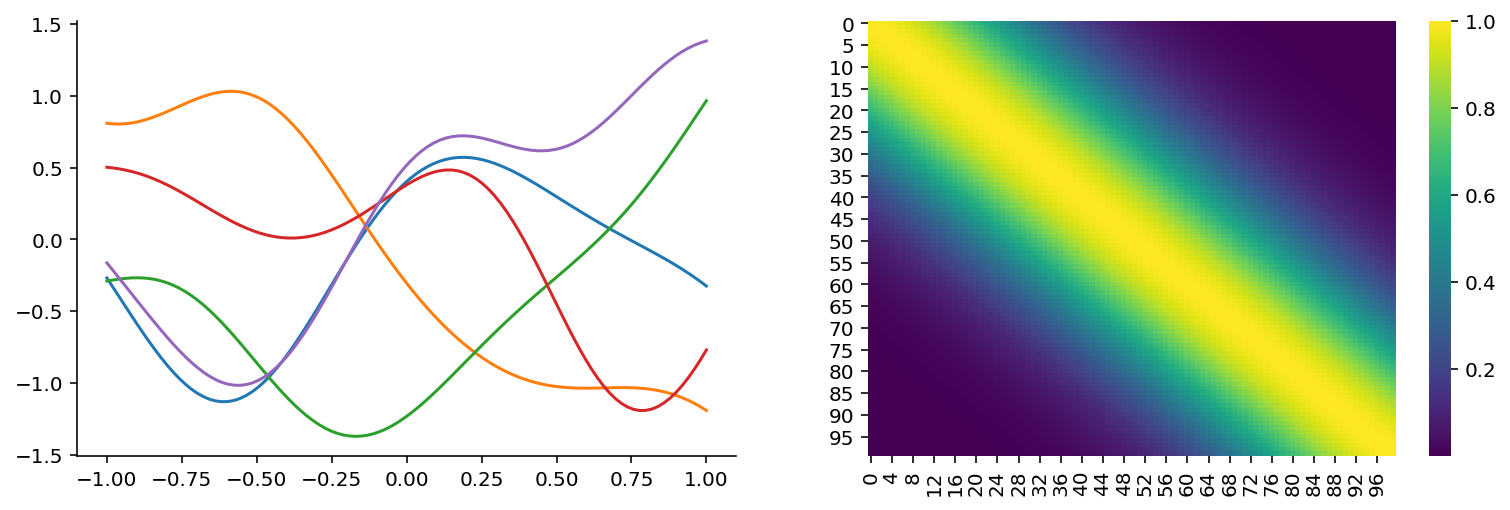

In [5]:
seed(314)
sigma = 0.2
E = np.zeros_like(x)
K = np.exp(-(x[:, np.newaxis] - x[np.newaxis, :])**2 / (2 * sigma))

fig, ax = plt.subplots(1, 2, figsize=(13, 4))
ax[0].plot(x, np.random.multivariate_normal(E, K, size=5).T)
sns.heatmap(K, cmap="viridis", ax=ax[1]);

### Ornstein-Uhlenbeck Process

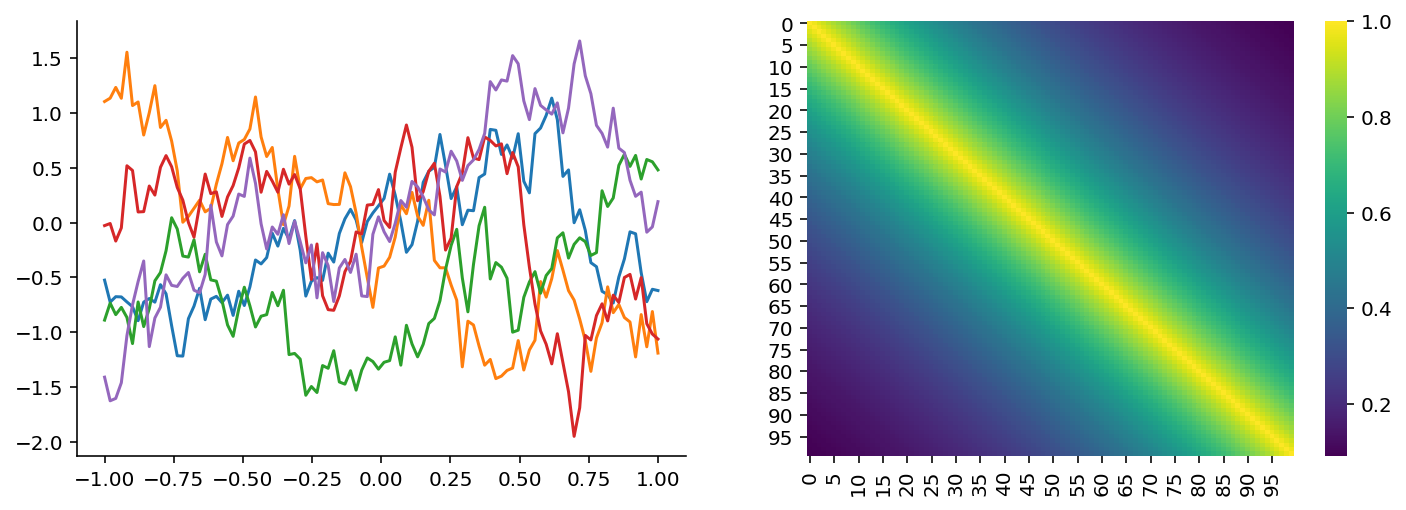

In [6]:
seed(314)
theta = 1.2
K = np.exp(-theta * np.abs(x[:, np.newaxis] - x[np.newaxis, :]))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(x, np.random.multivariate_normal(E, K, size=5).T)
sns.heatmap(K, cmap="viridis", ax=ax[1]);

### One widely used kernel function

$$
    k({\bf x}_n, {\bf x}_m) = \theta_0 \exp\left(-\frac{\theta_1}{2}||{\bf x}_n - {\bf x}_m||^2\right) + \theta_2 + \theta_3 {\bf x}_n^T{\bf x}_m
$$

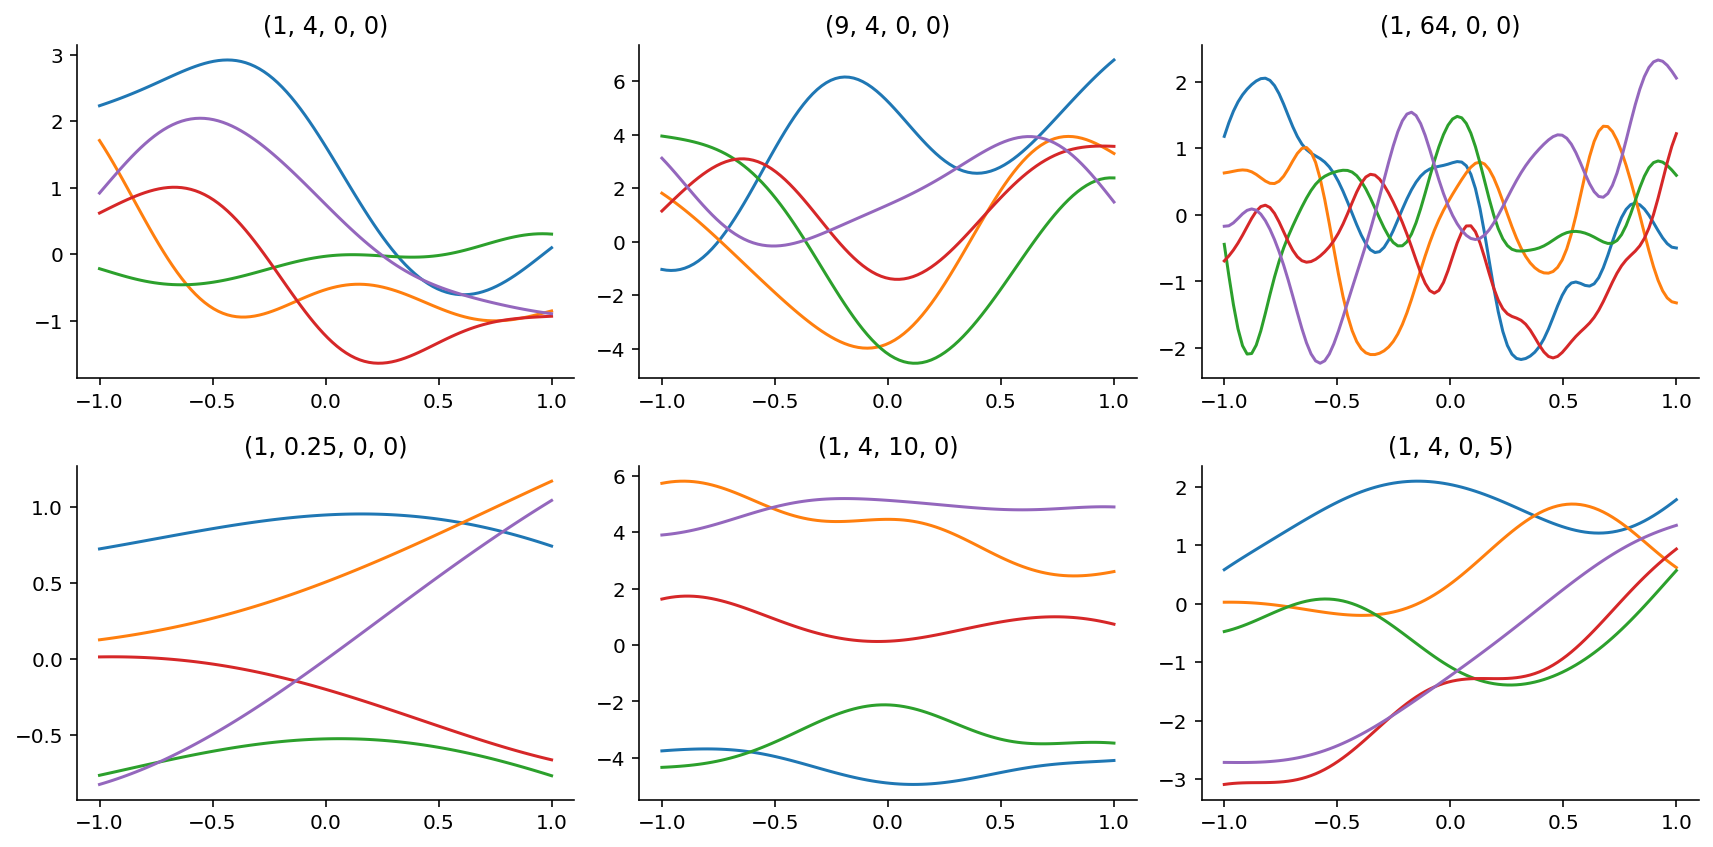

In [7]:
T_collection = [(1, 4, 0, 0), (9, 4, 0, 0), (1, 64, 0, 0),
                (1, 0.25, 0, 0), (1, 4, 10, 0), (1, 4, 0, 5)]

seed(1643)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()
for axi, (t0, t1, t2, t3) in zip(ax, T_collection):
    K = t0 * np.exp(-t1 / 2 * (x[:, np.newaxis] - x[np.newaxis, :]) ** 2) + t2 + t3 * x[:, np.newaxis] * x[np.newaxis, :]
    axi.plot(x, np.random.multivariate_normal(E, K, size=5).T)
    axi.set_title(f"({t0}, {t1}, {t2}, {t3})")
plt.tight_layout()

# Prior and Posterior Gaussian Processes

The marginal (prior) function distribution is given by
$$
    p({\bf y}) = \mathcal{N}({\bf y} | {\bf 0}, {\bf K})
$$

The marginal (posterior) function distribution is given by 

$$
\begin{align}
    p({\bf t}) &= \mathcal{N}({\bf t}| {\bf 0}, \beta^{-1}{\bf I}_n + {\bf K})\\
    &= \mathcal{N}({\bf t}| {\bf 0}, {\bf C}_N)
\end{align}
$$

After observing $N$ realizations of the target vector, corresponding to the input matrix ${\bf X} \in \mathbb{R}^{N\times M}$, futher $L$ estimations corresponding to the input matrix ${\bf X}_{N+L} \in \mathbb{R}^{L\times M}$ are given by the conditional probability
$$
    p({\bf t}_L|{\bf t}_N, {\bf X}, {\bf X}_{N + L}) = \mathcal{N}\left({\bf t}_L | {\bf k}^T_L{\bf C}_L^{-1}{\bf t}_N, {\bf k}^T_L{\bf C}_L^{-1}{\bf k}\right)
$$

In [8]:
seed(1643)
xtest = np.linspace(0, 1.3, 100)
E = np.zeros_like(xtest)
sigma = 0.05
K_prior = np.exp(-(xtest[:, np.newaxis] - xtest[np.newaxis, :])**2 / (2 * sigma))

In [9]:
x = np.array([0.1, 0.2, 0.25, 0.8, 0.9])
y = np.array([1.3, 1.1, 0.9, 0.85, 0.6])[:, np.newaxis]

In [10]:
beta_inv = 0.01
# CN is the posterior covariace matrix corresponding to the
# posterior values
CN = x[:, np.newaxis] - x[np.newaxis, :]
CN = np.exp(-CN ** 2 / (2 * sigma)) + np.eye(len(CN)) * beta_inv

In [11]:
K = x[:, np.newaxis] - xtest[np.newaxis, :]
K = np.exp(-K ** 2 / (2 * sigma))

In [12]:
# CL: covariance matrix for the values to estimate(we do not)
# know the real tn
CL = xtest[:, np.newaxis] - xtest[np.newaxis, :]
CL = np.exp(-CL ** 2 / (2 * sigma))

In [13]:
mu_post = K.T @ inv(CN) @ y
sigma_post = CL - K.T @ inv(CN) @ K 

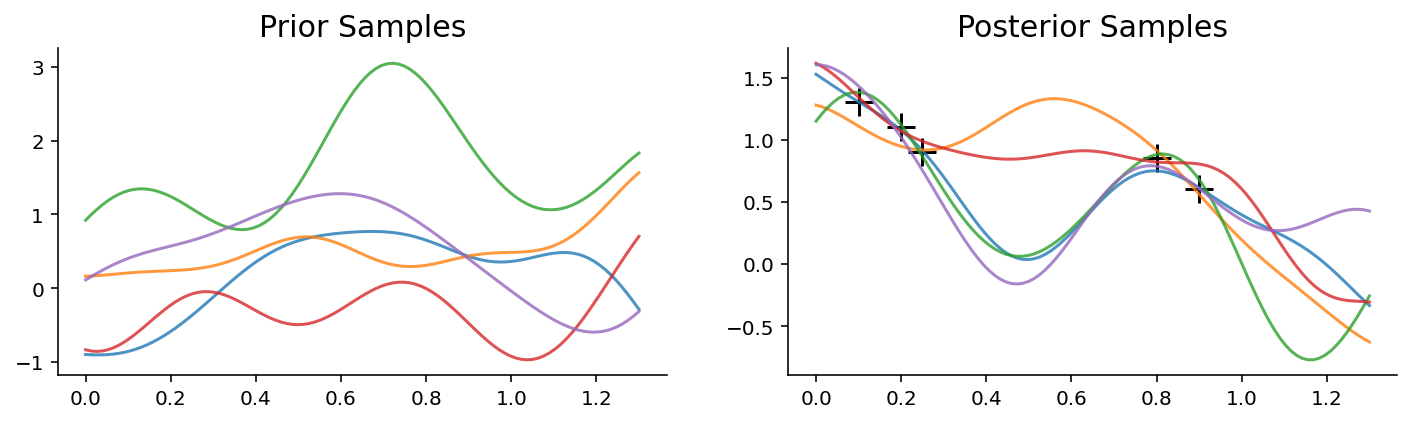

In [14]:
seed(314)
posterior_sample = np.random.multivariate_normal(mu_post.ravel(), sigma_post, size=5)
prior_sample = np.random.multivariate_normal(E, K_prior, size=5)

fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].plot(xtest, prior_sample.T, alpha=0.8);
ax[1].plot(xtest, posterior_sample.T, alpha=0.8);
ax[1].scatter(x, y, marker="+", s=200, c="black")
ax[0].set_title("Prior Samples", fontsize=15)
ax[1].set_title("Posterior Samples", fontsize=15);

<AxesSubplot:>

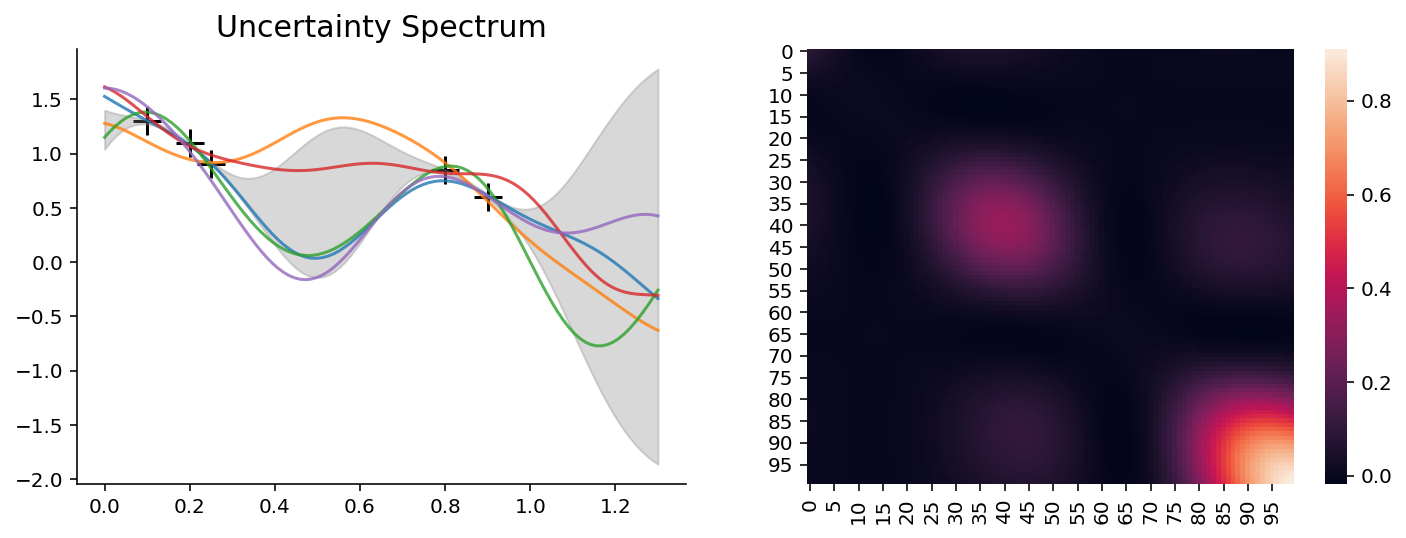

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

upper_bound = mu_post.ravel() + 2 * np.diag(sigma_post)
lower_bound = mu_post.ravel() - 2 * np.diag(sigma_post)
ax[0].scatter(x, y, marker="+", s=200, c="black")
ax[0].fill_between(xtest, upper_bound, lower_bound, color="tab:gray", alpha=0.3)
ax[0].plot(xtest, posterior_sample.T, alpha=0.8)
ax[0].set_title("Uncertainty Spectrum", fontsize=15);
sns.heatmap(sigma_post, ax=ax[1])